In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats


sns.set_style("whitegrid")
sns.set(font='serif')
sns.set_style("white", {
  "font.family": "serif",
  "font.serif": ["Times", "Palatino", "serif"],
})

FILENAME = 'official_10folds_results_resnet50_xception'

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_results(df):
    unique_values = df['model'].unique()

    resnet_results = df[df['model'] == unique_values[0]]
    xception_results = df[df['model'] == unique_values[1]]

    fig, axes = plt.subplots(1, 2, figsize=(22, 10))

    x_min = 0.3
    x_max = 0.9

    markers = ['o', 's', '^', 'v', '<', '>', 'p']  # Define marker styles

    for i, plot in enumerate([
        {"df": resnet_results, "model": "ResNet50"},
        {"df": xception_results, "model": "Xception"}
    ]):
        # Create a pointplot for each subplot
        ax = sns.pointplot(
            data=plot['df'],
            x='f1-score(weighted avg)',
            y='Severity',
            hue='strategy',
            linestyles='none',
            markers=markers[:len(plot['df']['strategy'].unique())],  # Use unique markers for strategies
            dodge=0.7,
            err_kws={'linewidth': 3},
            errorbar=('ci', 95),
            ax=axes[i]
        )

        ax.set_xlabel("F1-Score", fontsize=42)
        ax.set_xlim(x_min, x_max)

        if i == 0:
            ax.set_ylabel("Severity", fontsize=42)
        else:
            ax.set_yticklabels([])
            ax.set_ylabel("")

        ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=1)
        ax.axhline(y=1.5, color='grey', linestyle='--', linewidth=1)
        ax.axhline(y=2.5, color='grey', linestyle='--', linewidth=1)
        ax.tick_params(axis='x', labelsize=32)
        ax.tick_params(axis='y', labelsize=24)
        ax.set_title(plot['model'], fontsize=42)

        # Remove the first and last x ticks
        x_ticks = ax.get_xticks()
        ax.set_xticks(x_ticks[1:-1])  # Skip the first and last ticks

    # Remove duplicate legends
    axes[0].legend_.remove()
    axes[1].legend_.remove()

    handles, labels = ax.get_legend_handles_labels()

    for handle in handles:
        handle.set_markersize(30)  # Increase the marker size

    # Add a single legend for the entire figure
    fig.legend(handles, labels, title="Strategy", loc='lower center', bbox_to_anchor=(0.5, -0.42), fontsize=42, title_fontsize=42, ncol=3)
    fig.suptitle('Distributions Domain Range', fontsize=50, y=1)
    plt.tight_layout()
    plt.savefig('../output/results_ci_each_domain.pdf', bbox_inches='tight')
    plt.show()

In [57]:
# Relate the OOD Characterization
results = pd.read_csv(f'../results/cifar10/{FILENAME}.csv')

results['evaluation_set'] = results['evaluation_set'].str.replace(' ', '_').str.lower()
results['evaluation_set'] = results['evaluation_set'].str.replace('-', '_').str.lower()

characterization_df = pd.read_csv('../results/cifar10/cifar_10_c_divergences_categories.csv')

characterization_df['corruption_type'] = characterization_df['corruption_type'].str.replace(' ', '_').str.lower()

merged_results = results.merge(
    characterization_df[['corruption_type', 'category']],
    left_on='evaluation_set',
    right_on='corruption_type',
    how='left'
)

merged_results['Severity'] = np.where(
    merged_results['evaluation_set'] == 'in_distribution',
    'In-Distribution',
    merged_results['category']
)

merged_results.drop(columns=['corruption_type'], inplace=True)
merged_results.drop(columns=['category'], inplace=True)

results = merged_results

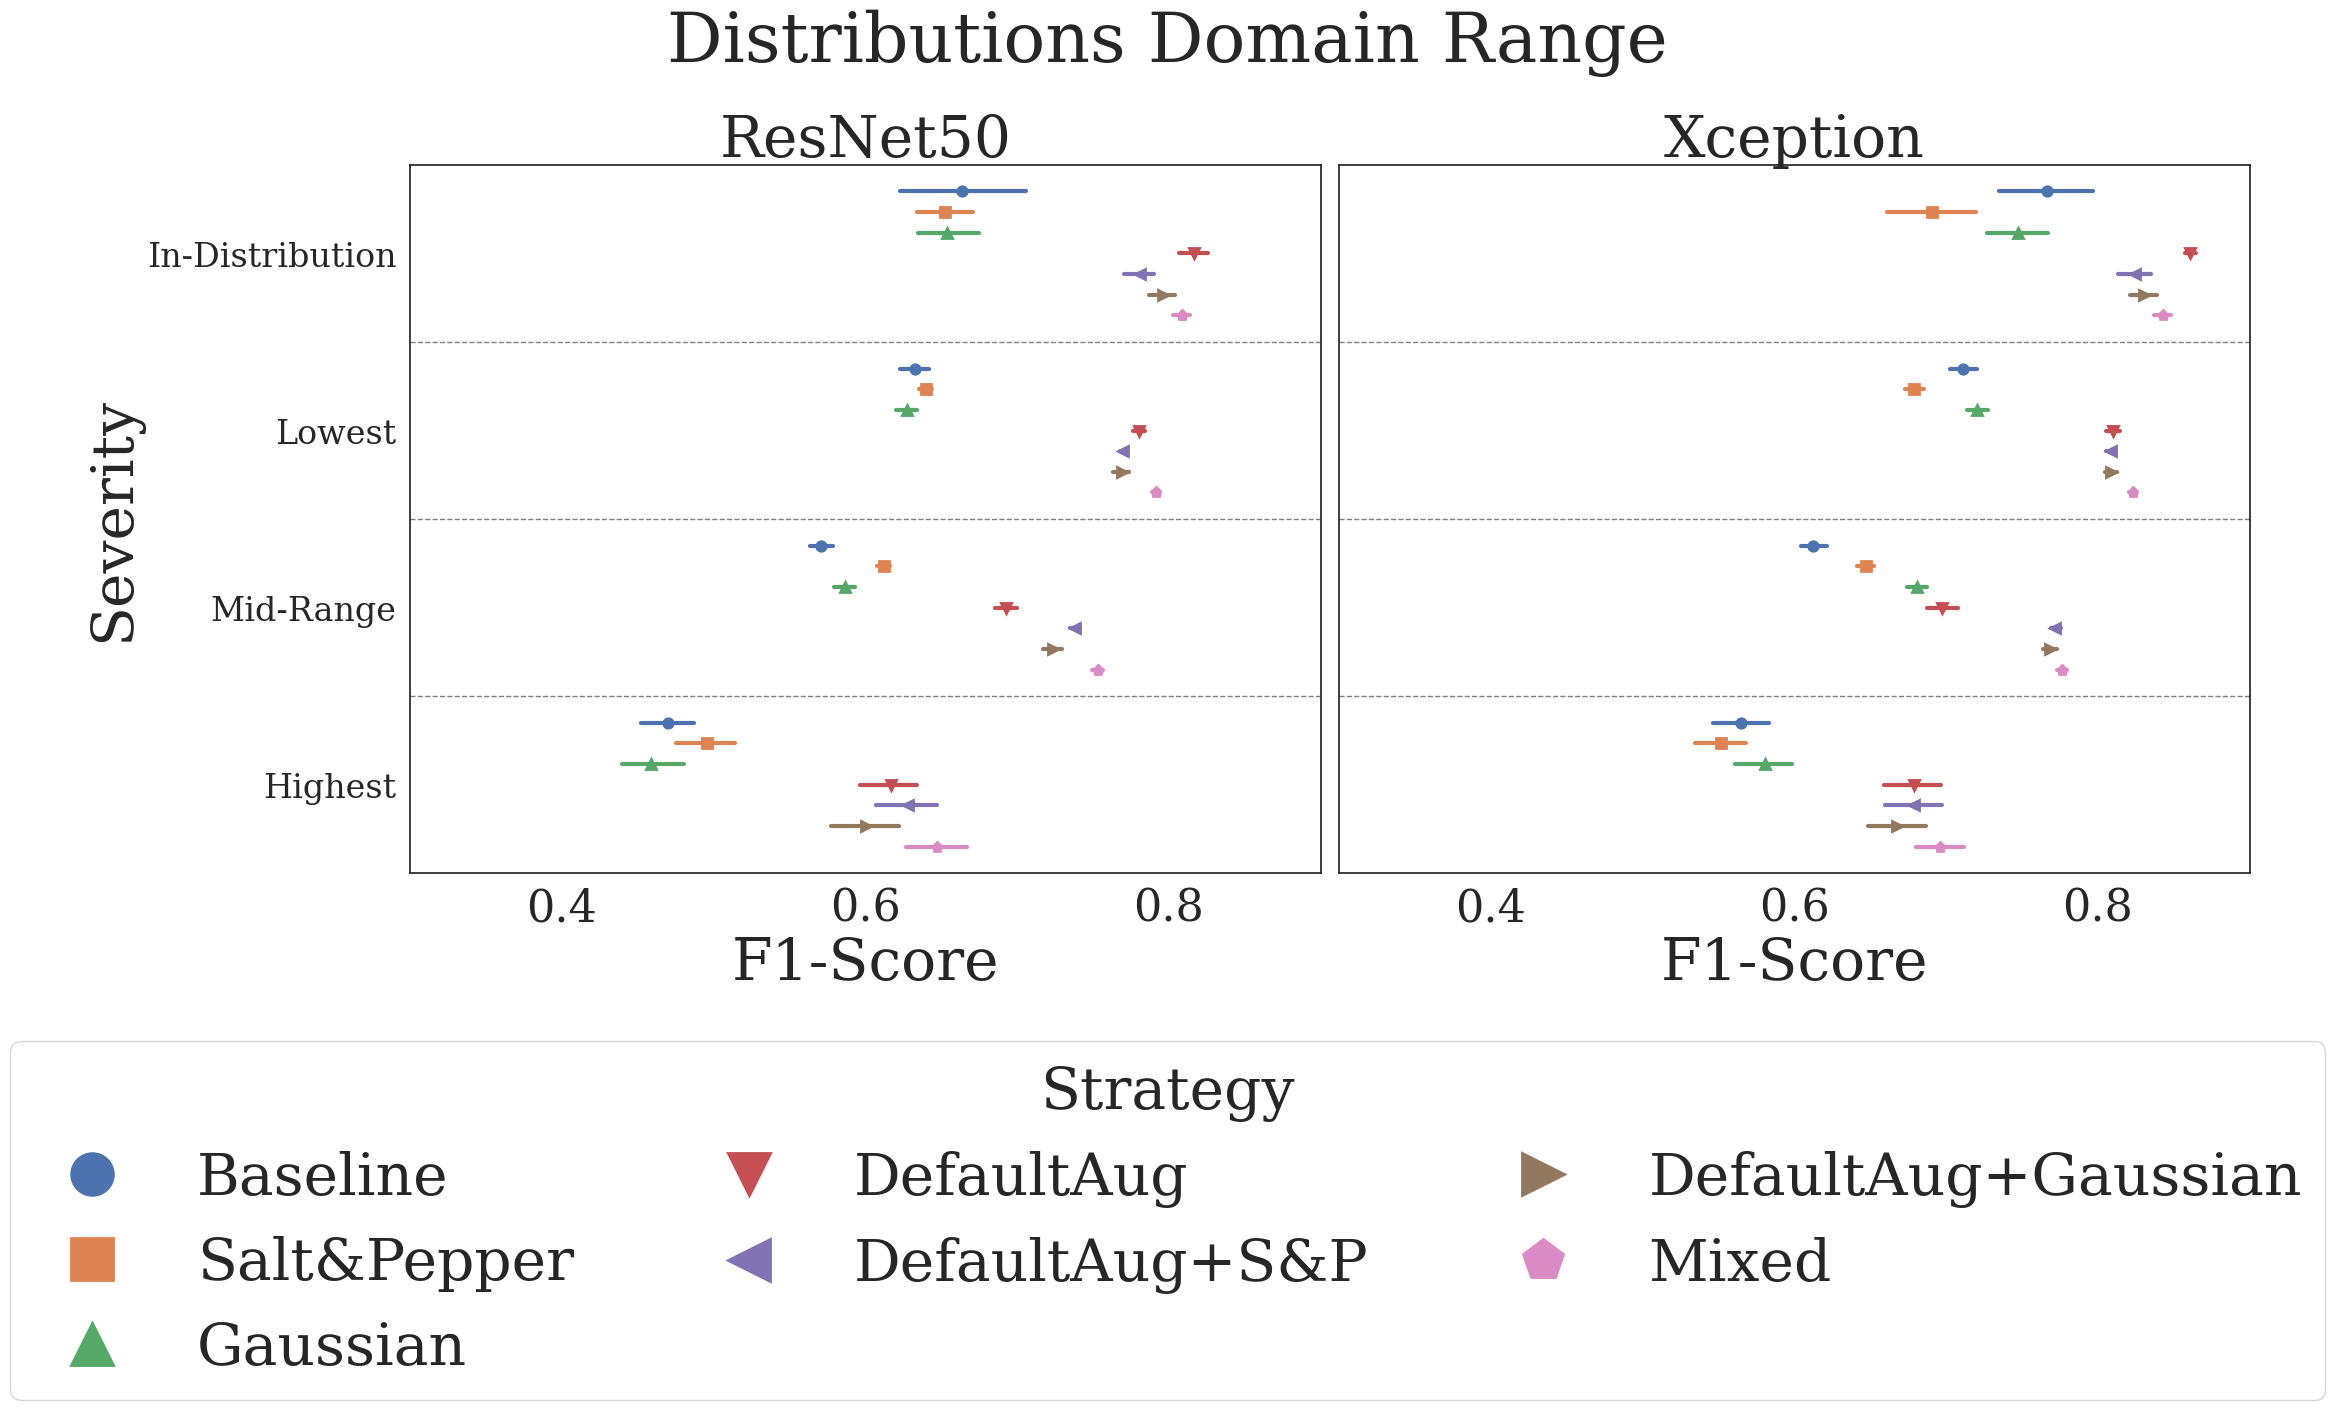

In [58]:
plot_results(results)

In [11]:
def bootstrap_confidence_interval(data, num_samples=1000, ci=0.95):
    data = np.array(data)

    res = stats.bootstrap((data,), np.mean, confidence_level=ci, n_resamples=num_samples, method='basic')
    return res.confidence_interval.low, res.confidence_interval.high

In [12]:
grouped = results.groupby(['model', 'strategy', 'Severity'])
confidence_intervals = grouped['f1-score(weighted avg)'].apply(lambda x: bootstrap_confidence_interval(x.values))
average_fscore = grouped['f1-score(weighted avg)'].mean()

confidence_intervals_df = pd.DataFrame({
    'Model': confidence_intervals.index.get_level_values('model'),
    'strategy': confidence_intervals.index.get_level_values('strategy'),
    'Severity': confidence_intervals.index.get_level_values('Severity'),
    'F-Score 95%': [f"{avg:.4f} ({lower:.4f}, {upper:.4f})" for (avg, (lower, upper)) in zip(average_fscore, confidence_intervals)]
})

confidence_intervals_df

,Model,strategy,Severity,F-Score 95%
0,ResNet50,Baseline,Highest,"0.4798 (0.4628, 0.4971)"
1,ResNet50,Baseline,In-Distribution,"0.6638 (0.6228, 0.7019)"
2,ResNet50,Baseline,Lowest,"0.6319 (0.6227, 0.6425)"
3,ResNet50,Baseline,Mid-Range,"0.5662 (0.5581, 0.5739)"
4,ResNet50,DefaultAug,Highest,"0.6307 (0.6125, 0.6490)"
5,ResNet50,DefaultAug,In-Distribution,"0.8166 (0.8073, 0.8264)"
6,ResNet50,DefaultAug,Lowest,"0.7811 (0.7769, 0.7855)"
7,ResNet50,DefaultAug,Mid-Range,"0.6853 (0.6776, 0.6943)"
8,ResNet50,DefaultAug+Gaussian,Highest,"0.6075 (0.5864, 0.6331)"
9,ResNet50,DefaultAug+Gaussian,In-Distribution,"0.7962 (0.7880, 0.8055)"
